In [1]:
#Importing Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.patches import ConnectionPatch
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor


In [2]:
#setting a seed to ensure reproducibility
SEED = 17
tf.keras.utils.set_random_seed(SEED)


In [3]:
#Matplotlib styling for visualization look nicer


plt.style.use('bmh')
plt.rc('axes', labelsize=10, labelweight='ultralight', titleweight='bold', titlesize='12',)
plt.rc('font', family='monospace' )
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
classes_palette = list(mcolors.TABLEAU_COLORS.values())
classes_palette.append('#000080')


In [4]:
#Planets Dataframe 
#eccentricity, semi-major axis, and inclination
planets = pd.DataFrame.from_dict({
    "Mercury": [0.206,  0.3871,  7.00],
    "Venus":   [0.007,  0.7233,  3.39],
    "Earth":   [0.017,  1.0000,  0.00],
    "Mars":    [0.093,  1.5273,  1.85],
    "Jupiter": [0.049,  5.2025,  1.3],
    "Saturn":  [0.056,  9.5415,  2.49],
    "Uranus":  [0.047, 19.188,  0.77],
    "Neptune": [0.010, 30.070,  1.77],
}, orient='index', columns=['e','a','i'])


In [5]:
#Calculating Aphelion and Perihelion distanc

planets['q'] = planets.apply(lambda row: row.a*(1-row.e), axis = 1)
planets['ad'] = planets.apply(lambda row: row.a*(1+row.e), axis = 1)


In [6]:
def plot_planets(xs, ys, ax, texts, c='black', xoffset=1., yoffset=1., **scatter_kwrgs):
    ax.scatter(xs, ys, c=c, **scatter_kwrgs)
    for x, y, text in zip(xs, ys, texts):
        ax.text(xoffset*x, yoffset*y, text, fontdict=dict(fontsize=8))
    return ax

def description(data):
    '''
    Returns the DataFrame representing a thorough description of the data.
    '''
    dtypes = data.dtypes
    counts = data.apply(lambda col: col.count())
    nulls = data.apply(lambda col: col.isnull().sum())
    nan_percent = nulls*100 / len(data)
    uniques = data.apply(lambda col: col.unique())
    n_uniques = data.apply(lambda col: col.nunique())
    
    cols = {'dtypes':dtypes, 'counts':counts, 'nulls' : nulls, 'nan_percent': nan_percent,
            'n_uniques':n_uniques, 'uniques':uniques}
    return pd.DataFrame(data=cols)


# Loading The Data

In [7]:
#Description

pd.DataFrame.from_dict({
    'name': 'object full name',
    'a': 'semi-major axis (au)',
    'e': 'eccentricity',
    'i': 'inclination; angle with respect to x-y elluptic plane (deg)',
    'om': 'longitude of the ascending node (deg)',
    'w': 'argument of perihelion (deg)',
    'q': 'perihelion distance (au)',
    'ad': 'aphelion distance (au)',
    'per_y': 'orbital period (years)',
    'data_arc': 'number of days spanned by the data arc(d)',
    'condition_code': 'orbit condition code',
    'n_obs_used': 'number of observations used',
    'H': 'absolute magnitude parameter',
    'neo': 'Near-Earth Object flag (Y/N)',
    'pha': 'Potentially Hazardous Asteroid flag (Y/N)',
    'diameter': 'object diameter (from equivalent sphere) (km)',
    'extent': 'object bi/tri-axial ellipsoid dimensions (km)',
    'albedo': 'geometric albedo',
    'rot_per': 'rotation period (h)',
    'GM': 'standard gravitational parameter, product of the mass (M) and gravitational constant (G)',
    'BV': 'color index B-V magnitude difference',
    'UB': 'color index U-B magnitude difference',
    'IR': 'color index I-R magnitude difference',
    'spec_B': 'spectral taxonomic type (SMASSII)',
    'spec_T': 'spectral taxonomic type (Tholen)',
    'G': 'magnitude slope parameter (default is 0.15)',
    'moid': 'Earth minimum orbit intersection distance (au)',
    'class': 'asteroid orbit class (f.e. MBA, OMB)',
    'n': 'mean motion (deg/d)',
    'per': 'orbital period (d)',
    'ma': 'mean anomaly (deg)',
}, orient='index', columns=['Description']).style.set_properties(**{'text-align': 'left'}).set_table_styles(
[dict(selector = 'th', props=[('text-align', 'left')])])

In [8]:
#Loading dataset
asteroid_ = pd.read_csv("/kaggle/input/prediction-of-asteroid-diameter/Asteroid_Updated.csv", 
                       low_memory=False)
asteroid = asteroid_.copy()
asteroid.T

0            1            2       \
name                            Ceres       Pallas         Juno   
a                            2.769165     2.772466      2.66915   
e                            0.076009     0.230337     0.256942   
i                           10.594067    34.836234    12.988919   
om                          80.305532   173.080063    169.85276   
w                           73.597694   310.048857   248.138626   
q                            2.558684     2.133865     1.983332   
ad                           2.979647     3.411067     3.354967   
per_y                        4.608202     4.616444     4.360814   
data_arc                       8822.0      72318.0      72684.0   
condition_code                      0            0            0   
n_obs_used                       1002         8490         7104   
H                                3.34         4.13         5.33   
neo                                 N            N            N   
pha                                 N            N            N   
diameter                        939.4          545      246.596   
extent          964.4 x 964.2 x 891.8  582x556x500          NaN   
albedo                           0.09        0.101        0.214   
rot_per                       9.07417       7.8132         7.21   
GM                            62.6284         14.3          NaN   
BV                              0.713        0.635        0.824   
UB                              0.426        0.284        0.433   
IR                                NaN          NaN          NaN   
spec_B                              C            B           Sk   
spec_T                              G            B            S   
G                                0.12         0.11         0.32   
moid                          1.59478      1.23324      1.03454   
class                             MBA          MBA          MBA   
n                            0.213885     0.213503     0.226019   
per                       1683.145708  1686.155999  1592.787285   
ma                          77.372096    59.699133    34.925016   

                               3            4            5            6       \
name                            Vesta      Astraea         Hebe         Iris   
a                            2.361418     2.574249      2.42516     2.385334   
e                            0.088721     0.191095     0.203007     0.231206   
i                            7.141771     5.366988    14.737901     5.523651   
om                         103.810804   141.576605   138.640203   259.563231   
w                          150.728541   358.687607    239.80749   145.265106   
q                            2.151909     2.082324     1.932835     1.833831   
ad                           2.570926     3.066174     2.917485     2.936837   
per_y                        3.628837     4.130323     3.776755     3.684105   
data_arc                      24288.0      63507.0      62329.0      62452.0   
condition_code                      0            0            0            0   
n_obs_used                       9325         2916         6034         5206   
H                                 3.2         6.85         5.71         5.51   
neo                                 N            N            N            N   
pha                                 N            N            N            N   
diameter                        525.4      106.699       185.18       199.83   
extent          572.6 x 557.2 x 446.4          NaN          NaN          NaN   
albedo                         0.4228        0.274       0.2679       0.2766   
rot_per                      5.342128       16.806       7.2745        7.139   
GM                               17.8          NaN          NaN          NaN   
BV                              0.782        0.826        0.822        0.855   
UB                              0.492        0.411        0.399        0.484   
IR                                NaN         

# Exploring The Data

In [9]:
#descrption of data

description(asteroid)

dtypes  counts   nulls  nan_percent  n_uniques  \
name             object   21967  817747    97.383990      21967   
a               float64  839712       2     0.000238     839702   
e               float64  839714       0     0.000000     839644   
i               float64  839714       0     0.000000     839623   
om              float64  839714       0     0.000000     839712   
w               float64  839714       0     0.000000     839709   
q               float64  839714       0     0.000000     839706   
ad              float64  839708       6     0.000715     839697   
per_y           float64  839713       1     0.000119     839697   
data_arc        float64  824240   15474     1.842770      21913   
condition_code   object  838847     867     0.103249         12   
n_obs_used        int64  839714       0     0.000000       3141   
H               float64  837025    2689     0.320228       9831   
neo              object  839708       6     0.000715          2   
pha              object  823272   16442     1.958048          2   
diameter         object  137636  702078    83.609181      16714   
extent           object      18  839696    99.997856         18   
albedo          float64  136409  703305    83.755302       1057   
rot_per         float64   18796  820918    97.761619      11230   
GM              float64      14  839700    99.998333         14   
BV              float64    1021  838693    99.878411        307   
UB              float64     979  838735    99.883413        339   
IR              float64       1  839713    99.999881          1   
spec_B           object    1666  838048    99.801599         34   
spec_T           object     980  838734    99.883294        131   
G               float64     119  839595    99.985829         47   
moid            float64  823272   16442     1.958048     295468   
class            object  839714       0     0.000000         14   
n               float64  839712       2     0.000238     839700   
per             float64  839708       6     0.000715     839696   
ma              float64  839706       8     0.000953     839699   

                                                          uniques  
name            [Ceres, Pallas, Juno, Vesta, Astraea, Hebe, Ir...  
a               [2.76916515450648, 2.772465921978979, 2.669149...  
e               [0.07600902910070946, 0.2303368211958249, 0.25...  
i               [10.59406704424526, 34.8362344173523, 12.98891...  
om              [80.30553156826473, 173.0800627473217, 169.852...  
w               [73.597694115971, 310.0488574270735, 248.13862...  
q               [2.558683599692926, 2.133864934636589, 1.98333...  
ad              [2.979646709320033, 3.41106690932137, 3.354966...  
per_y           [4.60820180153985, 4.61644352793619, 4.3608139...  
data_arc        [8822.0, 72318.0, 72684.0, 24288.0, 63507.0, 6...  
condition_code          [0, 2, 1, 4, 3, 5, nan, 8, 9, 7, 6, E, D]  
n_obs_used      [1002, 8490, 7104, 9325, 2916, 6034, 5206, 274...  
H               [3.34, 4.13, 5.33, 3.2, 6.85, 5.71, 5.51, 6.49...  
neo                                                   [N, Y, nan]  
pha                                                   [N, Y, nan]  
diameter        [939.4, 545, 246.596, 525.4, 106.699, 185.18, ...  
extent          [964.4 x 964.2 x 891.8, 582x556x500, nan, 572....  
albedo          [0.09, 0.101, 0.214, 0.4228, 0.274, 0.2679, 0....  
rot_per         [9.07417, 7.8132, 7.21, 5.34212766, 16.806, 7....  
GM              [62.6284, 14.3, nan, 17.8, 7.0, 1.53, 0.491, 0...  
BV              [0.713, 0.635, 0.824, 0.782, 0.826, 0.822, 0.8...  
UB              [0.426, 0.284, 0.433, 0.492, 0.411, 0.399, 0.4...  
IR                                                   [nan, -0.33]  
spec_B          [C, B, Sk, V, S, nan, L, Ch, X, Sl, Xk, Cb, Sq...  
spec_T          [G, B, S, V, C, M, E, FC, P, CG, X, CU, CF, XC...  
G               [0.12, 0.11, 0.32, nan, 0.24, 0.28, 0.17, 0.22...  
moid            [1.59478, 1.23324, 1

In [10]:
#count the no.of missing values
asteroid.diameter.isnull().sum()

702078

In [11]:
#removes missing value ,converts datatype of dia , display shape

asteroid = asteroid[asteroid.diameter.notnull()]
asteroid[['diameter']] = asteroid[['diameter']].astype(np.float64)
asteroid.shape

(137636, 31)

Text(0.5, 0, '')

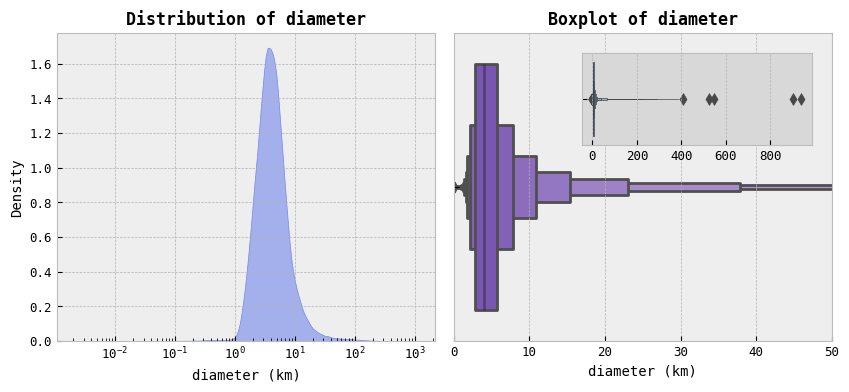

In [12]:
# Create a figure object with a specific size of 10 inches in width and 4 inches in height.
fig = plt.figure(figsize=(10, 4))

# Adjust the spacing between subplots horizontally.
plt.subplots_adjust(wspace=0.05)

# Create the first subplot (1 row, 2 columns) and set its position to 1.
plt.subplot(121, xlabel='diameter (km)', title='Distribution of diameter')

# Create a kernel density estimate (KDE) plot using Seaborn to visualize the distribution of asteroid diameters.
sns.kdeplot(data=asteroid, x='diameter', fill=True, log_scale=True, color='#7387EB', alpha=0.6)

# Create the second subplot (1 row, 2 columns) and set its position to 2.
plt.subplot(122, title='Boxplot of diameter', xlim=(0, 50))

# Create a boxen plot using Seaborn to visualize the distribution of asteroid diameters.
sns.boxenplot(data=asteroid, x='diameter', color='#7647C2')

# Set the x-axis label for the second subplot.
plt.gca().set(xlabel='diameter (km)')

# Add an additional axis for zooming in on the boxen plot.
fig.add_axes([0.65, 0.6, 0.23, 0.23])

# Create a boxen plot in the zoomed-in area.
zoom_out_ax = sns.boxenplot(data=asteroid, x='diameter', linewidth=0.5)

# Set the background color for the zoomed-in boxen plot.
zoom_out_ax.set_facecolor('#D8D8D8')

# Remove the x-axis label for the zoomed-in plot.
plt.xlabel('')


In [13]:
#missing values of neo and pha
asteroid['neo'].isnull().sum(), asteroid['pha'].isnull().sum()

(0, 0)

[Text(0, 0.5, ' ')]

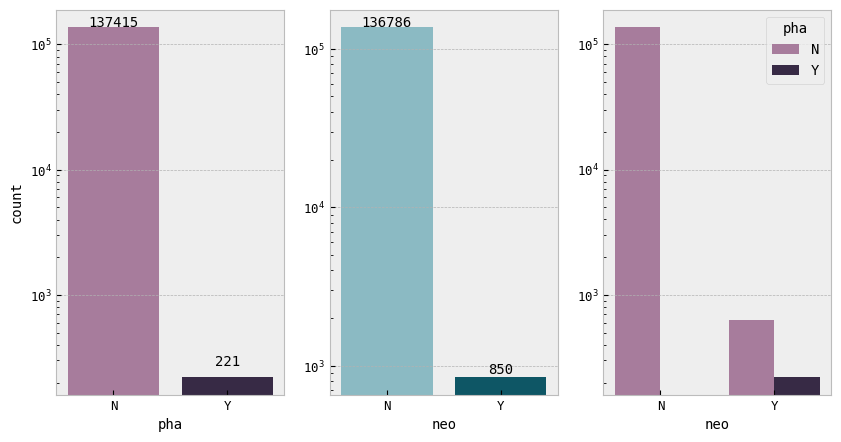

In [14]:
# Define a function to add labels to bar plots
def add_barlabel(rects, labels):
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        # Add a label to each bar at the center of the bar
        ax.text(rect.get_x() + rect.get_width()/2, height + 50, label, ha='center')

# Create a new figure with a specified size
plt.figure(figsize=(10,5))

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Create the first subplot in a 1x3 grid with a logarithmic y-scale
plt.subplot(131, yscale='log')
ax = sns.countplot(x=asteroid['pha'], palette=['#ae759f', '#372549'])
# Add labels to the bars in the first subplot
add_barlabel(ax.patches, asteroid['pha'].value_counts().values)

# Create the second subplot with a logarithmic y-scale
plt.subplot(132, yscale='log')
ax = sns.countplot(x=asteroid['neo'], palette=['#82c0cc', '#005f73'])
# Remove the y-label in the second subplot
ax.set(ylabel=' ')
# Add labels to the bars in the second subplot
add_barlabel(ax.patches, asteroid['neo'].value_counts().values)

# Create the third subplot with a logarithmic y-scale
plt.subplot(133, yscale='log')
ax = sns.countplot(x=asteroid['neo'], hue=asteroid['pha'], palette=['#ae759f', '#372549'])
# Remove the y-label in the third subplot
ax.set(ylabel=' ')


In [15]:
asteroid['class'].isnull().sum()

0

In [16]:
# Set Pandas display option to show columns with unlimited width
pd.set_option('display.max_colwidth', None)

# Define a Python dictionary containing information about asteroid classes
dic = {
    'MBA': ['Main-belt Asteroid',
            'Objects orbiting between Mars and Jupiter in the main portion of the asteroid belt.',
            '2.0 au < a < 3.2 au;  q > 1.666 au'],
    'OMB': ['Outer Main-belt Asteroid',
            'Objects orbiting between Mars and Jupiter in the outer reaches of the main asteroid belt.',
            '3.2 au < a < 4.6 au'],
    'TJN': ['Jupiter Trojan',
            "Objects trapped in Jupiter's L4/L5 in Lagrange points, share Jupiter's orbit around the sun.",
            '4.6 au < a < 5.5 au, e < 0.3'],
    'IMB': ['Inner Main-belt Asteroid',
            "Objects orbiting between Mars and Jupiter within the inner portion of the asteroid belt. ",
            'a < 2.0 au; q > 1.666 au'],
    'APO': ['Apollo',
            'Near-Earth asteroids whose orbit crosses the orbit of Earth.',
            'a > 1.0 au; q < 1.017 au'],
    'MCA': ['Mars-crossing Asteroids',
            'Objects with an orbit that crosses the orbit of Mars.',
            '1.3 au < q < 1.666 au; a < 3.2 au'],
    'AMO': ['Amor',
            'Near-Earth asteroids whose orbit approaches the orbit of Earth but does not cross it',
            'a > 1.0 au; 1.017 au < q < 1.3 au'],
    'ATE': ['Aten',
            'Near-Earth asteroids whose orbit could bring it in close proximity to Earth. ',
            'a < 1.0 au; ad > 0.983 au'],
    'CEN': ['Centaur',
            'Objects with an orbit between Jupiter and Neptune.',
            '5.5 au < a < 30.1 au'],
    'TNO': ['Trans-Neptunian Object',
            'Objects with orbits outside Neptune.',
            'a > 30.1 au'],
    'AST': ['Asteroid (other)',
            'Asteroid orbit not matching any defined orbit class.',
            ' ']  
}

# Create a Pandas DataFrame from the dictionary, specifying column names and using the dictionary keys as the index
asteroid_classes = pd.DataFrame.from_dict(dic, columns=['Name', 'Description', 'Details'], orient='index')

# Display the resulting DataFrame
asteroid_classes


Name  \
MBA        Main-belt Asteroid   
OMB  Outer Main-belt Asteroid   
TJN            Jupiter Trojan   
IMB  Inner Main-belt Asteroid   
APO                    Apollo   
MCA   Mars-crossing Asteroids   
AMO                      Amor   
ATE                      Aten   
CEN                   Centaur   
TNO    Trans-Neptunian Object   
AST          Asteroid (other)   

                                                                                      Description  \
MBA           Objects orbiting between Mars and Jupiter in the main portion of the asteroid belt.   
OMB     Objects orbiting between Mars and Jupiter in the outer reaches of the main asteroid belt.   
TJN  Objects trapped in Jupiter's L4/L5 in Lagrange points, share Jupiter's orbit around the sun.   
IMB     Objects orbiting between Mars and Jupiter within the inner portion of the asteroid belt.    
APO                                  Near-Earth asteroids whose orbit crosses the orbit of Earth.   
MCA                                         Objects with an orbit that crosses the orbit of Mars.   
AMO          Near-Earth asteroids whose orbit approaches the orbit of Earth but does not cross it   
ATE                 Near-Earth asteroids whose orbit could bring it in close proximity to Earth.    
CEN                                            Objects with an orbit between Jupiter and Neptune.   
TNO                                                          Objects with orbits outside Neptune.   
AST                                          Asteroid orbit not matching any defined orbit class.   

                                Details  
MBA  2.0 au < a < 3.2 au;  q > 1.666 au  
OMB                 3.2 au < a < 4.6 au  
TJN        4.6 au < a < 5.5 au, e < 0.3  
IMB            a < 2.0 au; q > 1.666 au  
APO            a > 1.0 au; q < 1.017 au  
MCA   1.3 au < q < 1.666 au; a < 3.2 au  
AMO   a > 1.0 au; 1.017 au < q < 1.3 au  
ATE           a < 1.0 au; ad > 0.983 au  
CEN                5.5 au < a < 30.1 au  
TNO                         a > 30.1 au  
AST

In [17]:
pd.set_option('display.max_colwidth', 50)

In [18]:
asteroid['class'].value_counts()

class
MBA    126390
OMB      7510
TJN      1874
IMB       588
APO       486
MCA       355
AMO       269
ATE        95
CEN        49
TNO        13
AST         7
Name: count, dtype: int64

/tmp/ipykernel_20/571007337.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121, xscale='log', xlabel='diameter(km)')
/tmp/ipykernel_20/571007337.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(122, xscale='log', xlabel='diameter(km)', ylabel=' ')


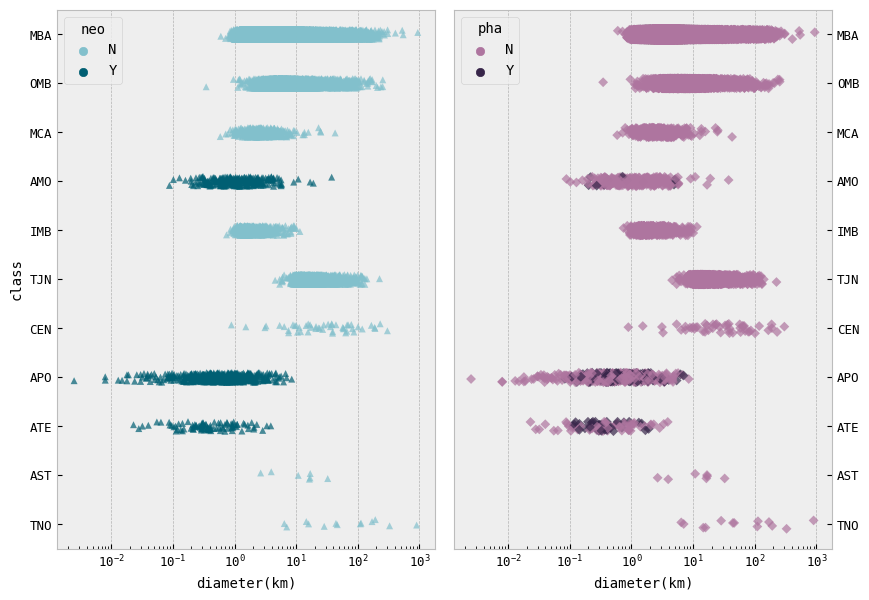

In [19]:
# potentially hazardous  of classes
fig, ax = plt.subplots(1,2, figsize=(10,7))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xscale='log', xlabel='diameter(km)')
sns.stripplot(data=asteroid, x='diameter', y='class', hue='neo', marker='^', alpha=0.7,
             palette=['#82c0cc', '#005f73'])

plt.subplot(122, xscale='log', xlabel='diameter(km)', ylabel=' ')
sns.stripplot(data=asteroid, x='diameter', y='class', hue='pha', marker='D', alpha=0.7,
             palette=['#ae759f', '#372549'])
plt.gca().yaxis.tick_right()

In [20]:
#asteroid in class ,neo
asteroid[['class','neo']].value_counts()

class  neo
MBA    N      126390
OMB    N        7510
TJN    N        1874
IMB    N         588
APO    Y         486
MCA    N         355
AMO    Y         269
ATE    Y          95
CEN    N          49
TNO    N          13
AST    N           7
Name: count, dtype: int64

[None, Text(0.5, 0, 'diameter (km)'), Text(0, 0.5, ' '), (0.01, 1)]

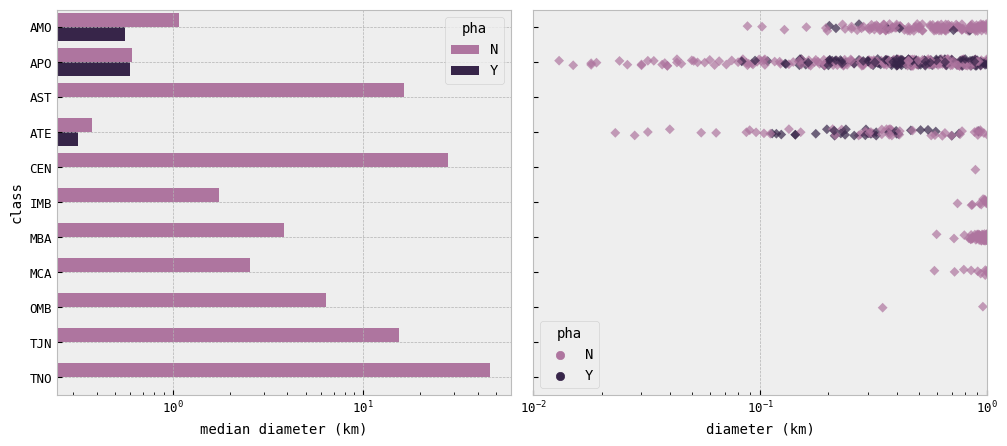

In [21]:
# Calculate median diameter w.r.t. class and pha flag.
grp = asteroid[['class','pha','diameter']].groupby(['class','pha']).median()

fig, ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
plt.subplots_adjust(wspace=0.05)

grp.unstack().plot(kind='barh', width=.8, color=['#ae759f', '#372549'], ax=ax[0])
ax[0].set(xscale='log', xlabel='median diameter (km)')
ax[0].legend(['N','Y'], title='pha')

sns.stripplot(data=asteroid.sort_values('class'), x='diameter', y='class', hue='pha', marker='D', 
              alpha=0.7, palette=['#ae759f', '#372549'], ax=ax[1])
ax[1].set(xscale='log', xlabel='diameter (km)', ylabel=' ', xlim=(0.01, 1))

In [22]:
#feature :name

# Some of the names given to asteroids in our dataset (without catalog numbers)
asteroid.name.unique()[10000:]

array(['Buncher', 'Davidharvey', 'Borel', ..., 'Hansklausreif',
       'Gustavomuler', 'Khalat'], dtype=object)

In [23]:
asteroid = asteroid.drop(['name'], axis=1)

In [24]:
#feature : a (semi-major axis)
asteroid.a.isnull().sum()

0

Text(0.5, 0, '')

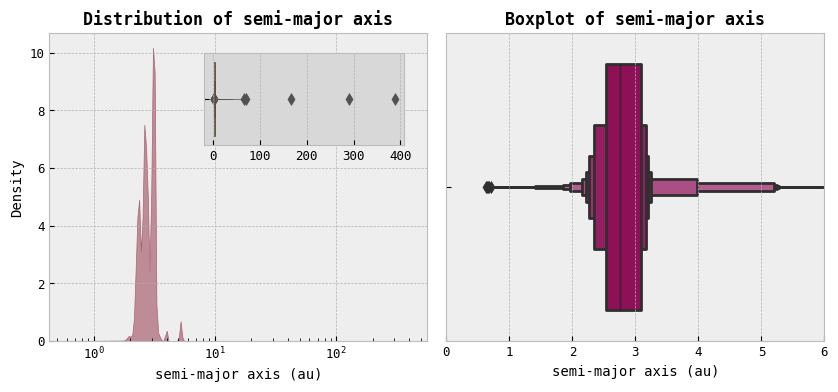

In [25]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='semi-major axis (au)', title='Distribution of semi-major axis')
sns.kdeplot(data=asteroid, x='a',fill=True, log_scale=True,  color='#aa6373', alpha=.7)

plt.subplot(122, title='Boxplot of semi-major axis', xlim=(0,6))
sns.boxenplot(data=asteroid, x='a', saturation=.8, color='#9e0059')
plt.gca().set(xlabel='semi-major axis (au)')

fig.add_axes([0.28,0.6,0.20,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='a', saturation=.8, color='#fca311', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')

[Text(0.5, 0, 'semi-major axis (au)'), None]

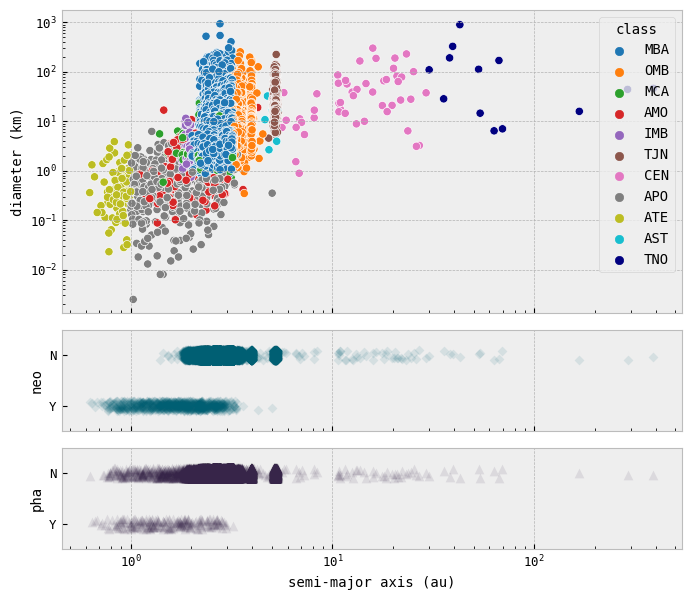

In [26]:
fig, ax = plt.subplots(3,1, figsize=(8,7), gridspec_kw={'height_ratios': [3,1,1]}, sharex=True)
plt.subplots_adjust(hspace=0.1)

sns.scatterplot(data=asteroid, x='a', y='diameter', hue='class', palette=classes_palette, ax=ax[0])
ax[0].set(ylabel='diameter (km)', xscale='log', yscale='log')

sns.stripplot(data=asteroid, x='a', y='neo', marker='D', s=5, alpha=.1, 
              jitter=True, color='#005f73',edgecolor='#001524', ax=ax[1])
ax[1].set(xscale='log')

sns.stripplot(data=asteroid, x='a', y='pha', marker='^', s=7, alpha=.1, 
              jitter=True, color='#372549', edgecolor='#001524', ax=ax[2])
ax[2].set(xlabel='semi-major axis (au)', xscale='log')

In [27]:
#feature:e (eccentricity)
asteroid.e.isnull().sum()

0

[Text(0.5, 0, 'eccentricity')]

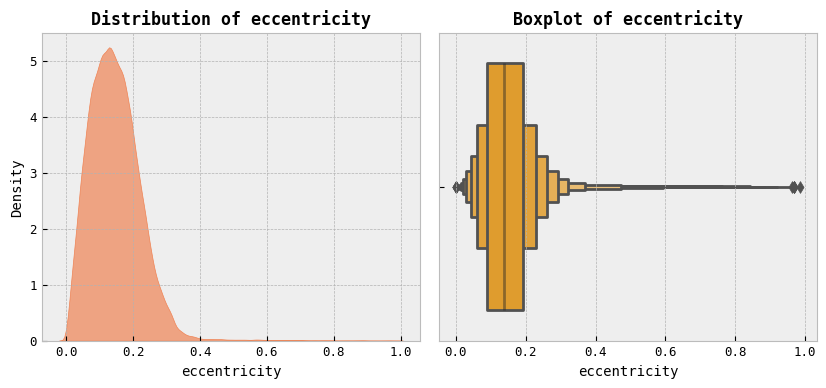

In [28]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='eccentricity', title='Distribution of eccentricity')
sns.kdeplot(data=asteroid, x='e',fill=True,  color='#ef8354', alpha=.7, )

plt.subplot(122, title='Boxplot of eccentricity')
sns.boxenplot(data=asteroid, x='e',color='#fca311')
plt.gca().set(xlabel='eccentricity',)

/tmp/ipykernel_20/4202733227.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,(1,3), xlabel='eccentricity', ylabel='diameter (km)', yscale='log')
/tmp/ipykernel_20/4202733227.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2, yscale='log',ylabel='diameter (km)')
/tmp/ipykernel_20/4202733227.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4, yscale='log', xlabel='eccentricity', ylabel='diameter (km)')


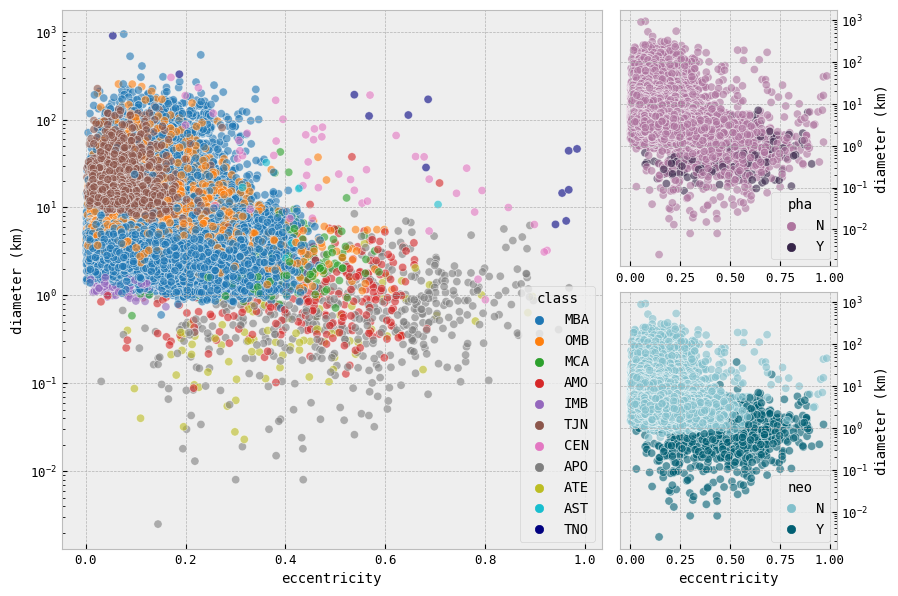

In [29]:
fig,ax = plt.subplots(2,2, figsize=(10,7), gridspec_kw={'width_ratios': [2.5,1]}, )
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2,2,(1,3), xlabel='eccentricity', ylabel='diameter (km)', yscale='log')
sns.scatterplot(data=asteroid, x='e', y='diameter', hue='class', palette=classes_palette, alpha=.6)

plt.subplot(2,2,2, yscale='log',ylabel='diameter (km)')
sns.scatterplot(data=asteroid, x='e', y='diameter', hue='pha', alpha=.6, 
                palette=['#ae759f', '#372549'],)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

plt.subplot(2,2,4, yscale='log', xlabel='eccentricity', ylabel='diameter (km)')
sns.scatterplot(data=asteroid, x='e', y='diameter', hue='neo', alpha=.6, 
                palette=['#82c0cc', '#005f73'])
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

In [30]:
asteroid[['e','class']].groupby(['class']).median().T

class      AMO       APO       AST       ATE       CEN       IMB       MBA  \
e      0.45487  0.543582  0.412453  0.373596  0.465996  0.082805  0.140421   

class       MCA       OMB      TJN       TNO  
e      0.322762  0.120815  0.07046  0.685937

In [31]:
#feature:q ( perihelion distance )
asteroid.q.isnull().sum()

0

Text(0.5, 0, '')

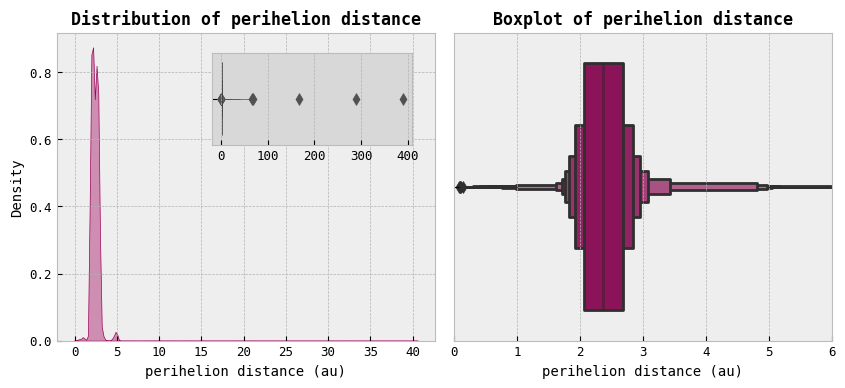

In [32]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='perihelion distance (au)', title='Distribution of perihelion distance')
sns.kdeplot(data=asteroid, x='q',fill=True, color='#9e0059', alpha=.4)

plt.subplot(122, title='Boxplot of perihelion distance', xlim=(0,6))
sns.boxenplot(data=asteroid, x='q',color='#9e0059')
plt.xlabel('perihelion distance (au)')

fig.add_axes([0.28,0.6,0.20,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='a', saturation=.8, color='#fca311', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')

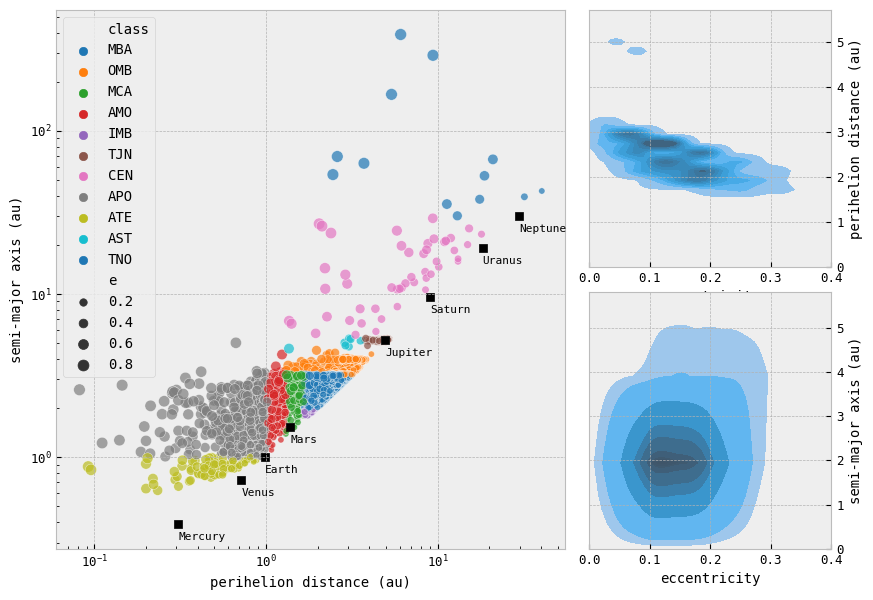

In [33]:
fig=plt.figure(figsize=(10,7))
ax= [None for _ in range(4)]

ax[0] = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
ax[1] = plt.subplot2grid((2,3), (0,2), colspan=1)
ax[2] = plt.subplot2grid((2,3), (1,2), colspan=1)
# ax[3] = plt.subplot2grid((3,3), (2,2), colspan=1)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Create a scatterplot.
sns.scatterplot(data=asteroid, x='q', y='a', hue='class', alpha=.7, palette='tab10', size='e', 
                ax=ax[0])
ax[0].set(xscale='log', yscale='log', xlabel='perihelion distance (au)', 
          ylabel='semi-major axis (au)', )
plt.grid(visible=True, which='minor', linestyle='--')
ax[0].legend(loc='upper left')

# Plot the planets.
plot_planets(planets.q, planets.a, texts=planets.index.values, xoffset=1, yoffset=.8, 
             marker='s', ax=ax[0])

# Bivariate distributions.
sns.kdeplot(data=asteroid, x='e', y='q',fill=True, ax=ax[1])
ax[1].set(xlim=(0,0.4), ylim=(0,5.7), xlabel='eccentricity', ylabel='perihelion distance (au)')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

sns.kdeplot(data=asteroid, x='e', y='a',fill=True, ax=ax[2])
ax[2].set(xlim=(0,0.4), ylim=(0,5.8), xlabel='eccentricity', ylabel='semi-major axis (au)')
ax[2].yaxis.set_label_position("right")
ax[2].yaxis.tick_right()

plt.show()

In [34]:
#feature:a(aphelion distance)
asteroid.ad.isnull().sum()

0

Text(0.5, 0, '')

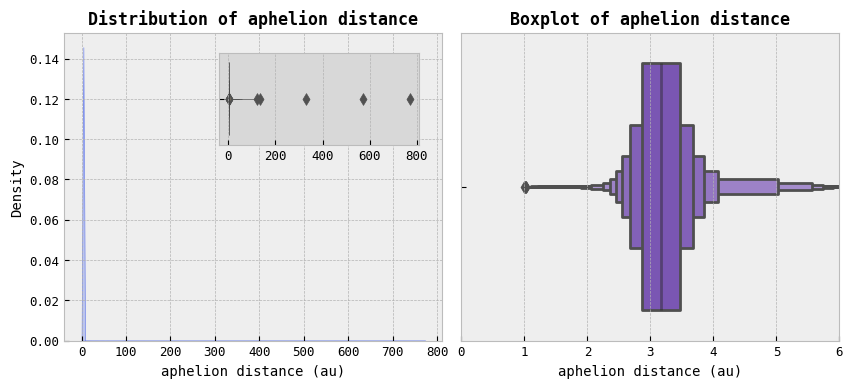

In [35]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(121, xlabel='aphelion distance (au)', title='Distribution of aphelion distance')
sns.kdeplot(data=asteroid, x='ad',fill=True, color='#7387EB', alpha=.4)

plt.subplot(122, title='Boxplot of aphelion distance', xlim=(0,6))
sns.boxenplot(data=asteroid, x='ad',color='#7647C2')
plt.xlabel('aphelion distance (au)')

fig.add_axes([0.28,0.6,0.20,0.23])
zoom_out_ax = sns.boxenplot(data=asteroid, x='ad', saturation=.8, color='#fca311', linewidth=.5)
zoom_out_ax.set_facecolor('#D8D8D8')
plt.xlabel('')

[None, Text(0.5, 0, 'aphelion distance (au)')]

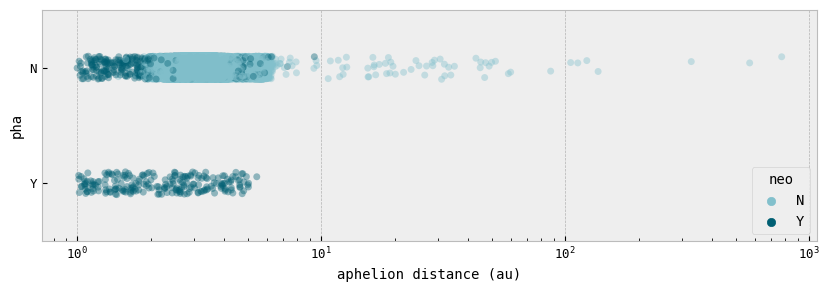

In [36]:
plt.figure(figsize=(10,3))
sns.stripplot(data=asteroid, x='ad', y='pha', hue='neo', alpha=0.4, palette=['#82c0cc', '#005f73'])
plt.gca().set(xscale='log', xlabel='aphelion distance (au)')

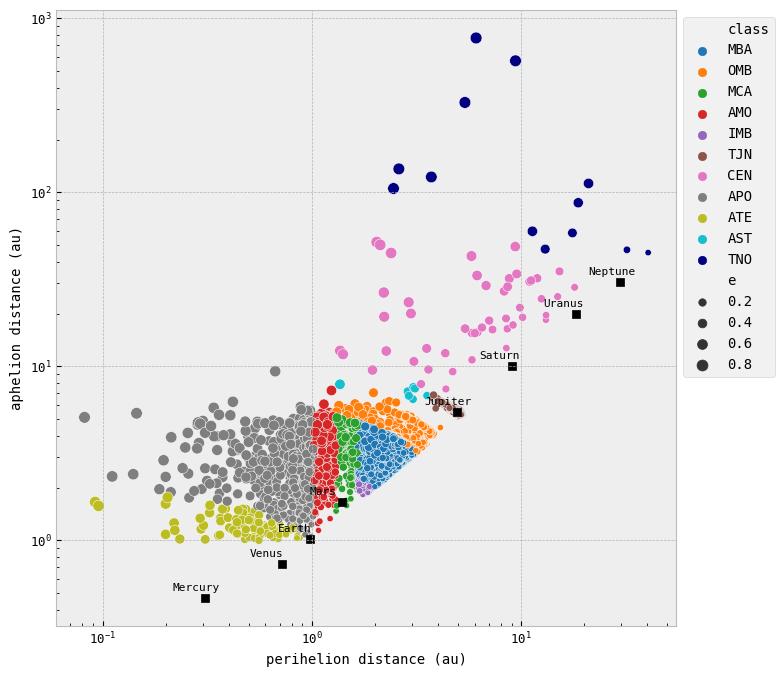

In [37]:
fig = plt.figure(figsize=(8,8))

sns.scatterplot(data=asteroid, x='q', y='ad', hue='class', palette=classes_palette, size='e')
plot_planets(planets.q, planets.ad, texts=planets.index.values, marker='s', ax=plt.gca(),
             xoffset=.7, yoffset=1.1)
plt.gca().set(xlabel='perihelion distance (au)', ylabel='aphelion distance (au)', xscale='log',
              yscale='log')
sns.move_legend(plt.gca(), loc='upper right', bbox_to_anchor=(1.17, 1.),)

plt.show()

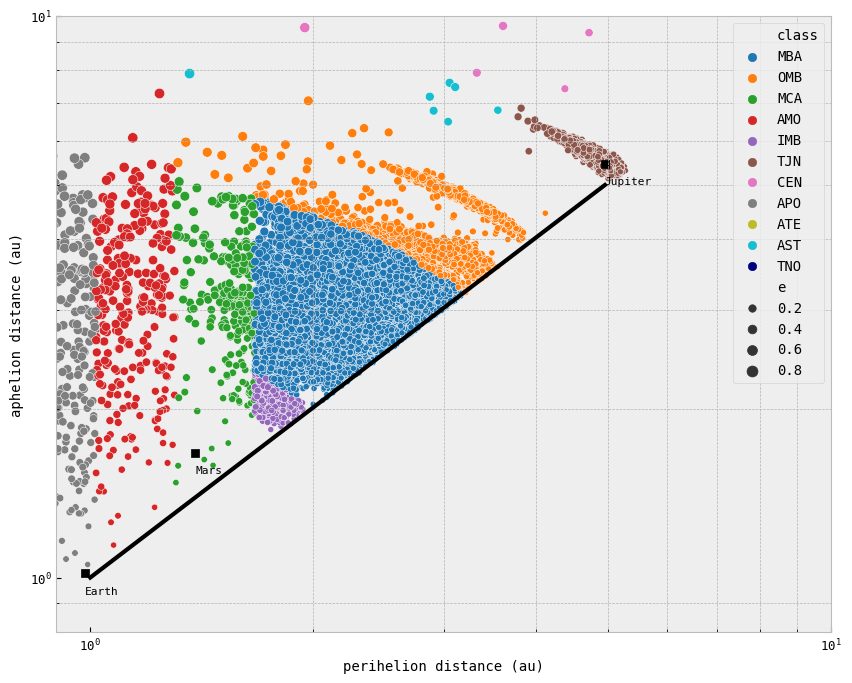

In [38]:
fig = plt.figure(figsize=(10,8))

sns.scatterplot(data=asteroid, x='q', y='ad', hue='class', palette=classes_palette, size='e')
plot_planets(planets[2:5].q, planets[2:5].ad, texts=planets[2:5].index.values, marker='s',
             ax=plt.gca(), xoffset=1., yoffset=0.92)
plt.plot([1, planets.loc["Jupiter"].q],[1, 5], lw=3, c='black')
plt.gca().set(xlabel='perihelion distance (au)', ylabel='aphelion distance (au)', xlim=(0.9,10),
              ylim=(0.8,10),xscale='log',yscale='log')
sns.move_legend(plt.gca(), loc='upper right',)
plt.minorticks_on()
plt.grid(which='both')

plt.show()

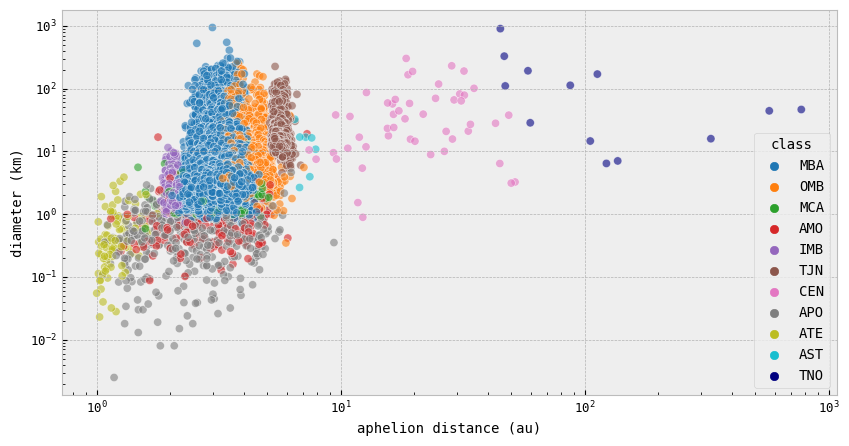

In [39]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(data=asteroid, x='ad', y='diameter', hue='class', palette=classes_palette, 
                     alpha=.6)
ax.set(xscale='log', yscale='log', xlabel='aphelion distance (au)', ylabel='diameter (km)',);

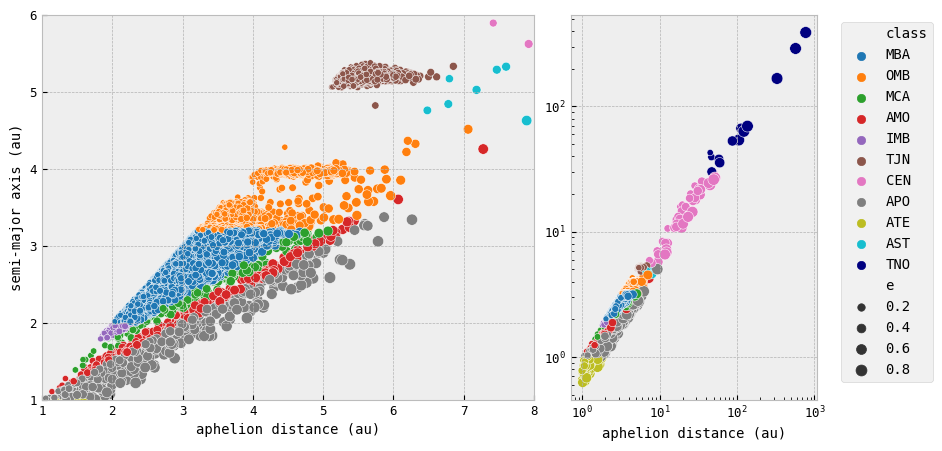

In [40]:
fig, ax = plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [2.,1]},)
plt.subplots_adjust(wspace=0.1)

sns.scatterplot(data=asteroid, x='ad', y='a', hue='class', palette=classes_palette, size='e',
               ax=ax[0])
ax[0].set(xlim=(1,8), ylim=(1,6), xlabel='aphelion distance (au)', ylabel='semi-major axis (au)')
ax[0].legend().set_visible(False)

sns.scatterplot(data=asteroid, x='ad', y='a', hue='class', palette=classes_palette, size='e', 
                ax=ax[1])
ax[1].set(xscale='log', yscale='log', ylabel=' ', xlabel='aphelion distance (au)')
sns.move_legend(ax[1], loc='upper right', bbox_to_anchor=(1.5, 1.),)

In [41]:
#feature:data-arc and n_obs_used ( the time between the first and last observations of an asteroid. ,total number of observations of an asteroid)

asteroid.data_arc.isnull().sum(), asteroid.n_obs_used.isnull().sum()

(138, 0)

In [42]:
asteroid['data_arc'].fillna(asteroid['data_arc'].median(), inplace=True)

Text(0.5, 0, 'data arc span(d)')

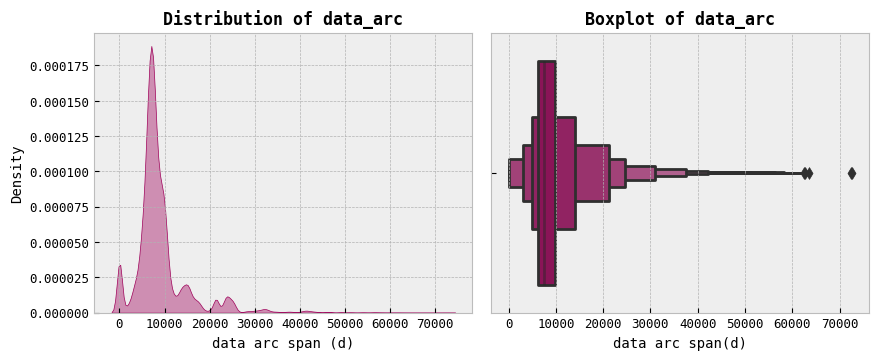

In [43]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='data arc span (d)', title='Distribution of data_arc', )
sns.kdeplot(data=asteroid, x='data_arc',fill=True, color='#9e0059', alpha=.4)

plt.subplot(222, title='Boxplot of data_arc', )
sns.boxenplot(data=asteroid, x='data_arc',color='#9e0059')
plt.xlabel('data arc span(d)')

Text(0.5, 0, 'no. observations used')

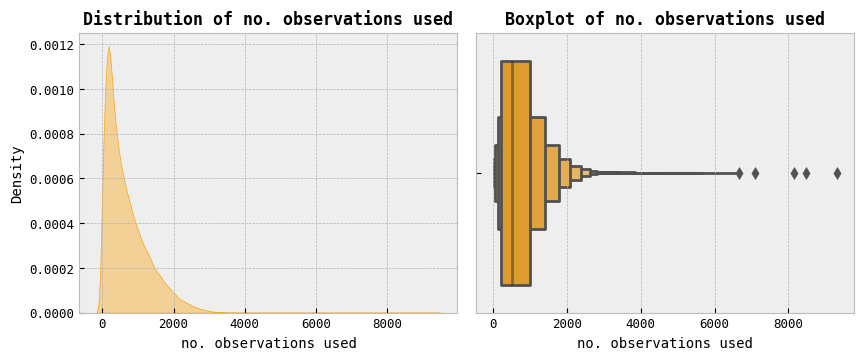

In [44]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='no. observations used', title='Distribution of no. observations used', )
sns.kdeplot(data=asteroid, x='n_obs_used',fill=True, color='#fca311', alpha=.4)

plt.subplot(222, title='Boxplot of no. observations used', )
sns.boxenplot(data=asteroid, x='n_obs_used',color='#fca311')
plt.xlabel('no. observations used')

In [45]:
# Convert days to years.
asteroid['data_arc'] = asteroid['data_arc']/365

/tmp/ipykernel_20/844638899.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(211, yscale='log', xscale='log',xlabel='data arc span (yrs)')
/tmp/ipykernel_20/844638899.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(212, xlabel='data arc span (yrs)')


<Axes: xlabel='data arc span (yrs)', ylabel='class'>

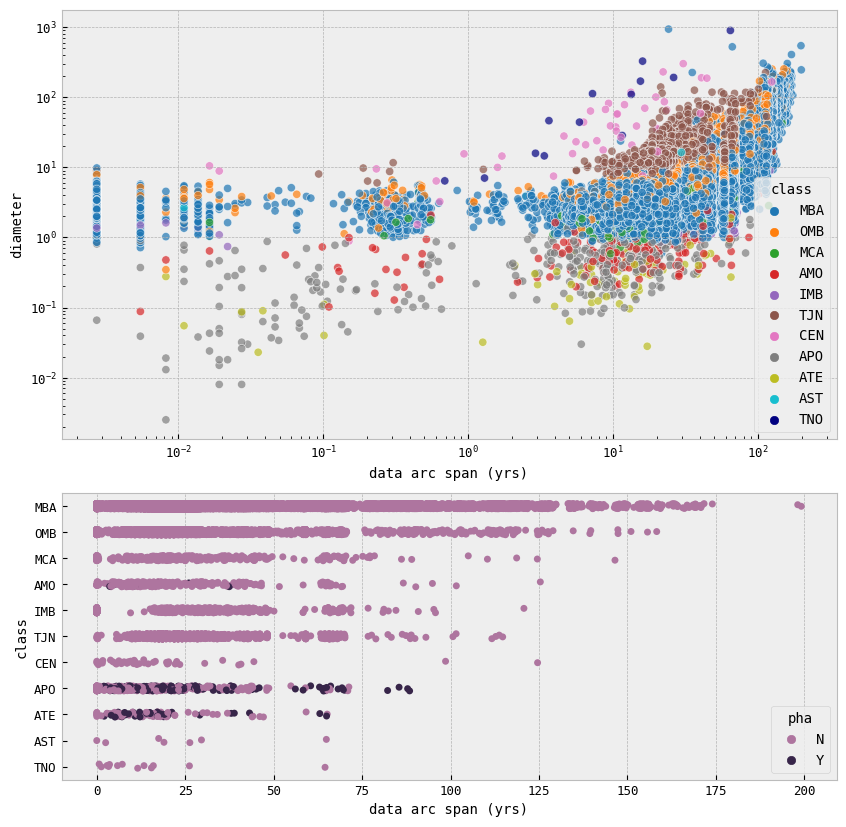

In [46]:
fig, ax = plt.subplots(2,1,figsize=(10,10),gridspec_kw={'height_ratios': [1.5,1]})
plt.subplots_adjust(hspace=0.15)

plt.subplot(211, yscale='log', xscale='log',xlabel='data arc span (yrs)')
sns.scatterplot(data=asteroid, x='data_arc', y='diameter', hue='class', palette=classes_palette, 
                alpha=.7)

plt.subplot(212, xlabel='data arc span (yrs)')
sns.stripplot(asteroid, x='data_arc', y='class', hue='pha', palette=['#ae759f', '#372549'] )

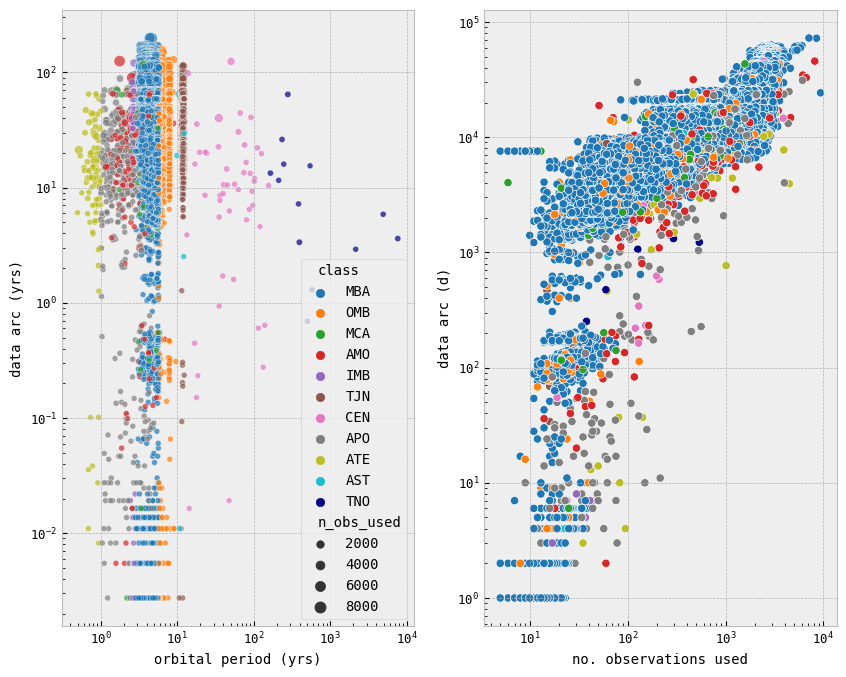

In [47]:
fig, ax = plt.subplots(1,2,figsize=(10,8),)
plt.subplots_adjust(wspace=0.2)

sns.scatterplot(x=asteroid['per_y'], y=asteroid['data_arc'], hue=asteroid['class'],  
                palette=classes_palette, alpha=.7, size=asteroid['n_obs_used'], ax=ax[0])
ax[0].set(xscale='log', yscale='log', ylabel='data arc (yrs)', xlabel='orbital period (yrs)')

sns.scatterplot(x=asteroid['n_obs_used'], y=asteroid['data_arc']*365, hue=asteroid['class'], 
                palette=classes_palette, ax=ax[1])
ax[1].set(xscale='log', yscale='log', ylabel='data arc (d)', xlabel='no. observations used')
plt.gca().get_legend().set_visible(False)

<Axes: xlabel='orbital period (yrs)', ylabel='no. observations used'>

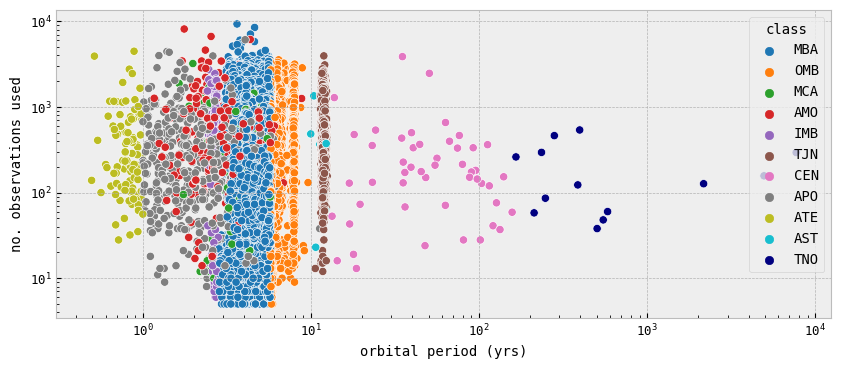

In [48]:
plt.figure(figsize=(10,4))
plt.subplot(111,  xscale='log', yscale='log',  ylabel='no. observations used', 
            xlabel='orbital period (yrs)')
sns.scatterplot(data=asteroid, x='per_y', y='n_obs_used', hue='class', palette=classes_palette,)

In [49]:
#feature:H (Absolute magnitude)

asteroid.H.isnull().sum()

747

Text(0.5, 0, 'absolute magnitude')

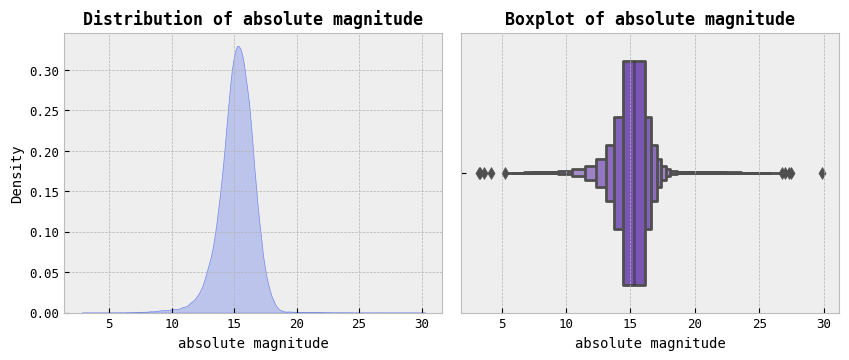

In [50]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='absolute magnitude', title='Distribution of absolute magnitude', )
sns.kdeplot(data=asteroid, x='H',fill=True, color='#7387EB', alpha=.4)

plt.subplot(222, title='Boxplot of absolute magnitude', )
sns.boxenplot(data=asteroid, x='H',color='#7647C2')
plt.xlabel('absolute magnitude')

In [51]:
#Missing Values Imputation
# Entries with absolute magnitude missing will be our test set.
missing_h = asteroid['H'].isnull()

In [52]:
# Our train/valid set.
asteroid_no_nan_h = asteroid.dropna(axis=0, subset=['H'])

# We'll use only one feature for predicting H, which is actually highly correlated with it.
X = asteroid_no_nan_h[['n_obs_used']]
y = asteroid_no_nan_h['H']
                  
# Split into train and validation sets.
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=.2, random_state=SEED)

In [53]:
X_test = asteroid.loc[missing_h, ['n_obs_used']]

# Train models and check performance on validation set.
lr = LinearRegression().fit(X_tr, y_tr)
knn = KNeighborsRegressor(n_neighbors=15, weights='distance').fit(X_tr, y_tr)

print('>> LR: {}'.format(mean_squared_error(y_val, lr.predict(X_val))))
print('>> KNN: {}'.format(mean_squared_error(y_val, knn.predict(X_val))))

# Make predictions for the test set.
lr_test_pred = lr.predict(X_test)
knn_test_pred = knn.predict(X_test)

>> LR: 0.7661167544896129
>> KNN: 0.7864244460503532


In [54]:
# Make a copy of the original dataset with new columns representing H column with imputed values 
# using different techniques.
asteroid_imputed_H = asteroid.copy()

for col_name, preds in zip(['H_imp_lr', 'H_imp_knn', 'H_imp_median'],
                           [lr_test_pred, knn_test_pred, asteroid_imputed_H.H.median()]):
    asteroid_imputed_H[col_name] = asteroid['H']
    asteroid_imputed_H.loc[missing_h, col_name] = preds

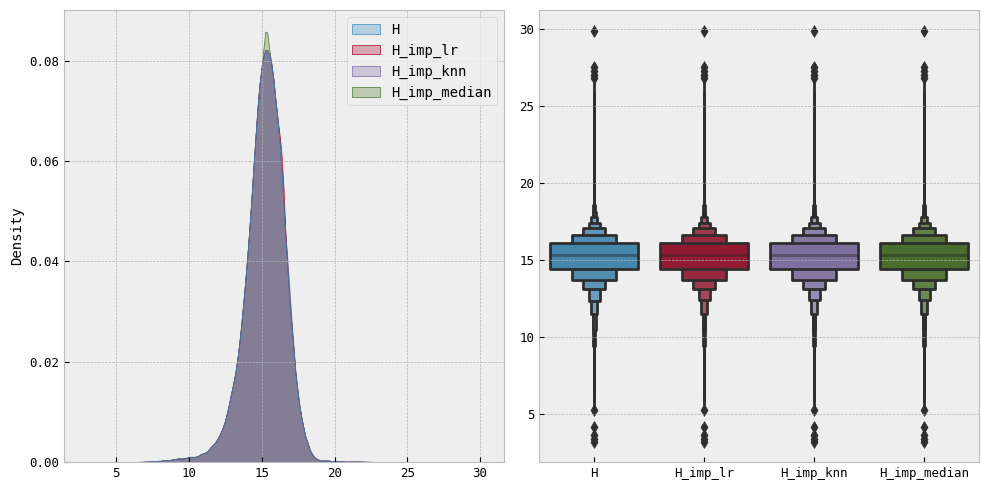

In [55]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

imp_res = asteroid_imputed_H[['H','H_imp_lr', 'H_imp_knn', 'H_imp_median']]

sns.kdeplot(data=imp_res, ax=ax[0], alpha=.3, fill=True)
sns.boxenplot(data=imp_res, ax=ax[1])
plt.tight_layout()

In [56]:
asteroid.loc[missing_h, 'H'] = lr_test_pred
asteroid.H.isnull().sum()

0

In [57]:
#feature:albedo (The albedo combined with the absolute magnitude can help determine the size of an asteroid.)

asteroid.albedo.isnull().sum()

1230

Text(0.5, 0, 'geometric albedo')

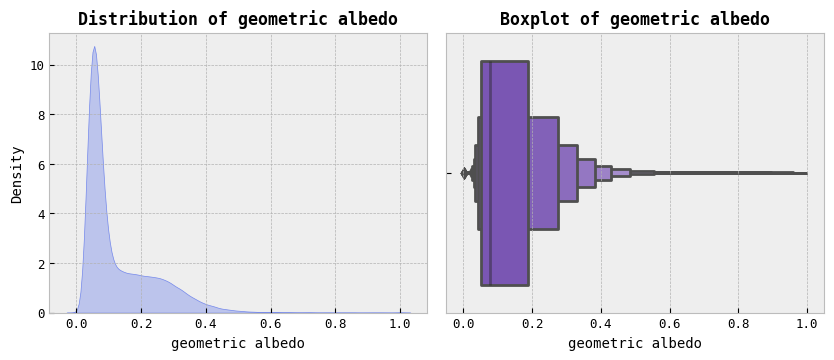

In [58]:
fig = plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.05)

plt.subplot(221, xlabel='geometric albedo', title='Distribution of geometric albedo', )
sns.kdeplot(data=asteroid, x='albedo',fill=True, color='#7387EB', alpha=.4)

plt.subplot(222, title='Boxplot of geometric albedo', )
sns.boxenplot(data=asteroid, x='albedo',color='#7647C2')
plt.xlabel('geometric albedo')

In [59]:
#Missing Values Imputation
# Entries with albedo missing - test set.
missing_albedo = asteroid['albedo'].isnull()

In [60]:
asteroid_no_nan_albedo = asteroid.dropna(axis=0, subset=['albedo'])

X = asteroid_no_nan_albedo[['diameter']]   # highly correlated with albedo
y = asteroid_no_nan_albedo['albedo']
                  
# Create train and validation sets.
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=.2, random_state=SEED)

In [61]:
X_test = asteroid.loc[missing_albedo, ['diameter']]

# Train models and check performance on validation set.
lr = LinearRegression().fit(X_tr, y_tr)
knn = KNeighborsRegressor(n_neighbors=5, weights='distance').fit(X_tr, y_tr)

print('>> LR: {}'.format(mean_squared_error(y_val, lr.predict(X_val))))
print('>> KNN: {}'.format(mean_squared_error(y_val, knn.predict(X_val))))

# Predict the test set values.
lr_test_pred = lr.predict(X_test)
knn_test_pred = knn.predict(X_test)

>> LR: 0.011894735521214783
>> KNN: 0.013409505469597906


In [62]:
# Make a copy of the dataset with new columns representing H column with imputed values using 
# different techniques.
asteroid_imputed_albedo = asteroid.copy()

for col_name, preds in zip(['albedo_imp_lr', 'albedo_imp_knn', 'albedo_imp_median'],
                           [lr_test_pred, knn_test_pred, asteroid_imputed_albedo.albedo.median()]):
    asteroid_imputed_albedo[col_name] = asteroid['albedo']
    asteroid_imputed_albedo.loc[missing_albedo, col_name] = preds

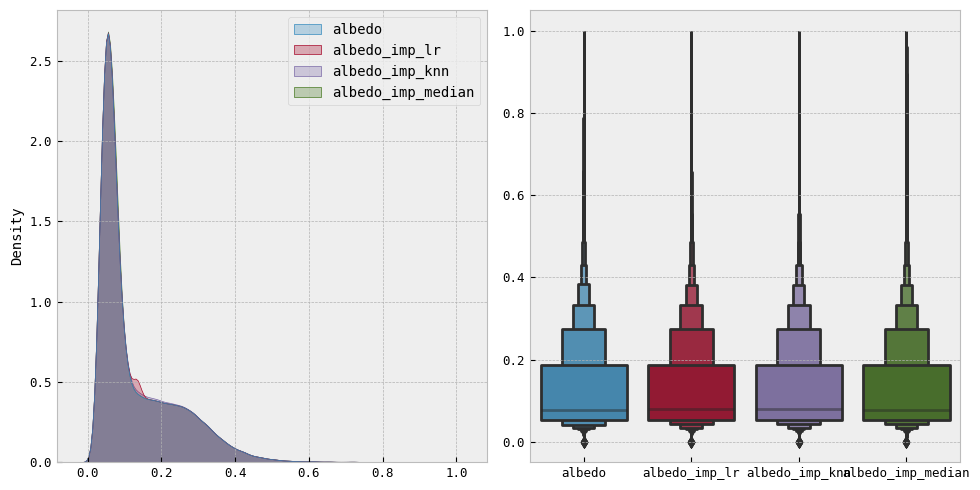

In [63]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

imp_res = asteroid_imputed_albedo[['albedo','albedo_imp_lr', 'albedo_imp_knn', 'albedo_imp_median']]

sns.kdeplot(data=imp_res, ax=ax[0], alpha=.3, fill=True)
sns.boxenplot(data=imp_res, ax=ax[1])
plt.tight_layout()

In [64]:
asteroid.loc[missing_albedo, 'albedo'] = knn_test_pred
asteroid.albedo.isnull().sum()

0

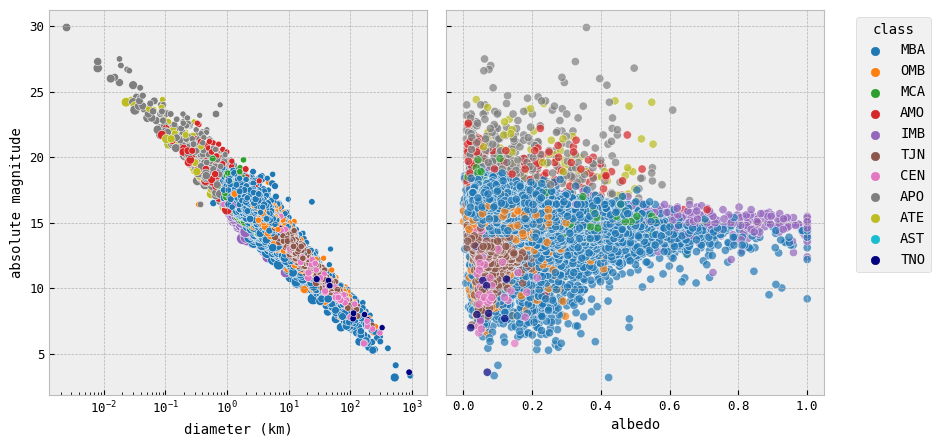

In [65]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.subplots_adjust(wspace=0.05)

ax[0].set(xscale='log', xlabel='diameter (km)', ylabel='absolute magnitude')
sns.scatterplot(asteroid, x='diameter', y='H', hue='class', palette=classes_palette, 
                size='albedo', ax=ax[0])
ax[0].legend().set_visible(False)

ax[1].set(xlabel='albedo',)
sns.scatterplot(asteroid, x='albedo', y='H', hue='class', palette=classes_palette, alpha=.7,
                ax=ax[1])
sns.move_legend(ax[1], "upper right", bbox_to_anchor=(1.3, 1.),)

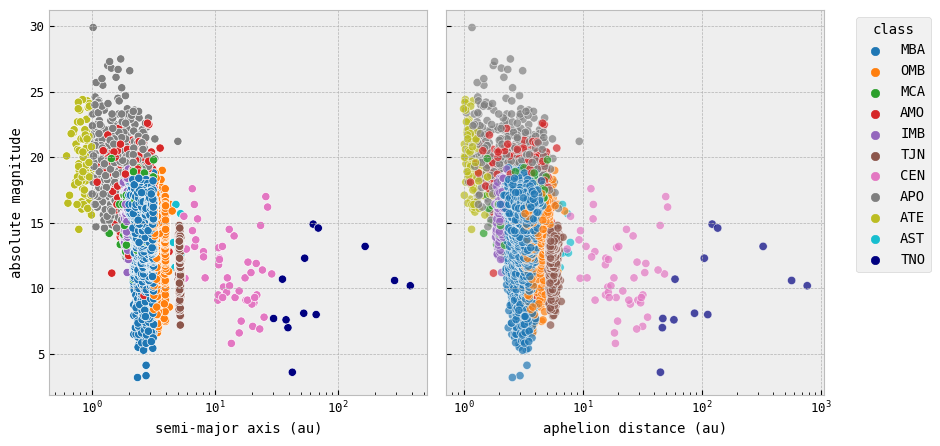

In [66]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
plt.subplots_adjust(wspace=0.05)

ax[0].set(xscale='log', xlabel='semi-major axis (au)', ylabel='absolute magnitude')
sns.scatterplot(asteroid, x='a', y='H', hue='class', palette=classes_palette, ax=ax[0])
ax[0].legend().set_visible(False)

ax[1].set(xlabel='aphelion distance (au)', xscale='log')
sns.scatterplot(asteroid, x='ad', y='H', hue='class', palette=classes_palette, alpha=.7,
                ax=ax[1])
sns.move_legend(ax[1], "upper right", bbox_to_anchor=(1.3, 1.),)

In [67]:
drop_cols = ['extent','rot_per','GM','BV','UB','IR','spec_B','spec_T','G','per']

asteroid = asteroid.drop(drop_cols, axis=1)

# Feature Engineering and Data Preprocessing

In [68]:
asteroid

a         e          i          om           w         q  \
0       2.769165  0.076009  10.594067   80.305532   73.597694  2.558684   
1       2.772466  0.230337  34.836234  173.080063  310.048857  2.133865   
2       2.669150  0.256942  12.988919  169.852760  248.138626  1.983332   
3       2.361418  0.088721   7.141771  103.810804  150.728541  2.151909   
4       2.574249  0.191095   5.366988  141.576605  358.687607  2.082324   
...          ...       ...        ...         ...         ...       ...   
797860  3.171225  0.159119  27.098625  309.036573   19.746812  2.666623   
798077  2.548410  0.076071  11.593237  246.298656  170.090810  2.354549   
798189  3.146246  0.220559  17.966646  137.981403  180.898833  2.452313   
799752  3.051336  0.287449  14.456779  343.917822  342.614839  2.174231   
810375  2.417477  0.109001   4.525668  148.244819   31.949854  2.153970   

              ad     per_y    data_arc condition_code  n_obs_used      H neo  \
0       2.979647  4.608202   24.169863              0        1002   3.34   N   
1       3.411067  4.616444  198.131507              0        8490   4.13   N   
2       3.354967  4.360814  199.134247              0        7104   5.33   N   
3       2.570926  3.628837   66.542466              0        9325   3.20   N   
4       3.066174  4.130323  173.991781              0        2916   6.85   N   
...          ...       ...         ...            ...         ...    ...  ..   
797860  3.675826  5.647402    6.501370              1          50  16.20   N   
798077  2.742270  4.068291    9.032877              2          33  17.30   N   
798189  3.840180  5.580811    7.778082              1          47  16.80   N   
799752  3.928440  5.330196    6.049315              2          27  17.20   N   
810375  2.680984  3.758822    9.473973              3          25  18.40   N   

       pha  diameter  albedo     moid class         n          ma  
0        N   939.400  0.0900  1.59478   MBA  0.213885   77.372096  
1        N   545.000  0.1010  1.23324   MBA  0.213503   59.699133  
2        N   246.596  0.2140  1.03454   MBA  0.226019   34.925016  
3        N   525.400  0.4228  1.13948   MBA  0.271609   95.861936  
4        N   106.699  0.2740  1.09589   MBA  0.238632  282.366289  
...     ..       ...     ...      ...   ...       ...         ...  
797860   N     3.793  0.0210  1.66301   MBA  0.174527  164.999439  
798077   N     2.696  0.0610  1.36733   MBA  0.242270  145.319581  
798189   N     2.917  0.1540  1.43837   MBA  0.176610  174.609920  
799752   N     3.271  0.0720  1.16684   MBA  0.184914  175.708508  
810375   N     1.600  0.0230  1.15942   MBA  0.262217  170.888415  

[137636 rows x 20 columns]

In [69]:
def estimate_diameter(a, H):
    '''A function for computing approximate asteroid diameter from its albedo and absolute magnitude.'''
    p = 3.1236 - 0.5*np.log10(a) - 0.2*H
    return 10**p

In [70]:
asteroid_transf = asteroid.copy()
asteroid_transf['approx_diameter']=estimate_diameter(asteroid_transf.albedo, asteroid_transf.H)

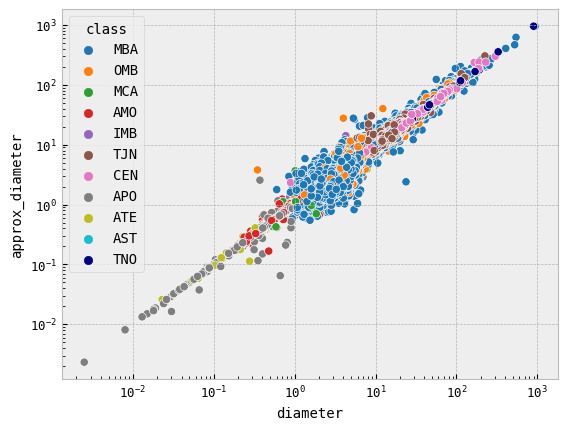

In [71]:
sns.scatterplot(data=asteroid_transf, x='diameter', y='approx_diameter',hue='class',
                palette=classes_palette)
plt.gca().set(xscale='log', yscale='log');


In [72]:
#Encoding the categorical features

# Perform one-hot encoding on categorical columns 
asteroid_transf = pd.get_dummies(asteroid_transf, dtype=int)
asteroid_transf.head()

a         e          i          om           w         q        ad  \
0  2.769165  0.076009  10.594067   80.305532   73.597694  2.558684  2.979647   
1  2.772466  0.230337  34.836234  173.080063  310.048857  2.133865  3.411067   
2  2.669150  0.256942  12.988919  169.852760  248.138626  1.983332  3.354967   
3  2.361418  0.088721   7.141771  103.810804  150.728541  2.151909  2.570926   
4  2.574249  0.191095   5.366988  141.576605  358.687607  2.082324  3.066174   

      per_y    data_arc  n_obs_used  ...  class_APO  class_AST  class_ATE  \
0  4.608202   24.169863        1002  ...          0          0          0   
1  4.616444  198.131507        8490  ...          0          0          0   
2  4.360814  199.134247        7104  ...          0          0          0   
3  3.628837   66.542466        9325  ...          0          0          0   
4  4.130323  173.991781        2916  ...          0          0          0   

   class_CEN  class_IMB  class_MBA  class_MCA  class_OMB  class_TJN  class_TNO  
0          0          0          1          0          0          0          0  
1          0          0          1          0          0          0          0  
2          0          0          1          0          0          0          0  
3          0          0          1          0          0          0          0  
4          0          0          1          0          0          0          0  

[5 rows x 42 columns]

In [73]:
#Train-test split
X = asteroid_transf.drop(['diameter'], axis=1)
y = asteroid_transf[['diameter']]

# Split into train/val and test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3,
                                                            random_state=SEED)
# Split into train set and val set.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size=0.15, random_state=SEED)

In [74]:
# Reset the index of each set after splitting.
X_train, X_val = X_train.reset_index(drop=True), X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [75]:
#Scaling numerical features
num_cols = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'n_obs_used',
            'H', 'albedo', 'moid', 'n', 'ma', 'approx_diameter']

scaler = StandardScaler()

# Scale the numerical features and then join these features with categorical ones.
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
X_train_sc = pd.concat([X_train_sc, X_train.loc[:, ~X_train.columns.isin(num_cols)]], 
                       axis=1)

X_val_sc = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)
X_val_sc = pd.concat([X_val_sc, X_val.loc[:, ~X_val.columns.isin(num_cols)]], 
                       axis=1)

X_test_sc = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)
X_test_sc = pd.concat([X_test_sc, X_test.loc[:, ~X_test.columns.isin(num_cols)]], 
                       axis=1)

In [76]:
scaler = StandardScaler()

# Scale the target variable.
y_train_sc = scaler.fit_transform(y_train)
y_val_sc, y_test_sc = scaler.transform(y_val), scaler.transform(y_test)

y_train_sc.shape, y_val_sc.shape, y_test_sc.shape

((81893, 1), (14452, 1), (41291, 1))

# Building and Fine_Tuning the Model

In [77]:
def evaluation_scatterplot(y_pred, y_true, **scatter_kwargs):  
    ''' 
    Creates a scatter plot of predictions and true values with logarithmic scale. Plots a diagonal line, 
    computes MSE & R2 scores for the values and adds them to the plot as an annotation.
    '''
    ax = sns.scatterplot(x=y_true['diameter'].ravel(), y=y_pred.flatten(), **scatter_kwargs)
    
    # Calculate diagonal line equation for the original scale
    x = np.logspace(np.log10(ax.get_xlim()[0]), np.log10(ax.get_xlim()[1]), num=100)
    y = x  
    
    # Plot the diagonal line in the logarithmic scale
    plt.plot(x, y, 'k--', lw=2)
    
    # Add annotation in the upper-left corner
    mse = mean_squared_error(y_true, y_pred).round(3)
    r2 = r2_score(y_true, y_pred).round(3)
    results= "MSE: {:.3f}\n R2: {:.3f}".format(mse,r2)
    plt.text(0.05, 0.95, results, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='left',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    return ax, mse, r2

In [78]:
# Reduced dataset
X_train_sc_red = X_train_sc.drop(['approx_diameter'], axis=1)
X_val_sc_red = X_val_sc.drop(['approx_diameter'], axis=1)
X_test_sc_red = X_test_sc.drop(['approx_diameter'], axis=1)

# MLP for Regression

In [79]:
model_entire = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

model_entire.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(), )

In [80]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model_entire.fit(X_train_sc, y_train_sc, epochs=50, 
                           validation_data=(X_val_sc, y_val_sc),
                           callbacks=[early_stopping_cb])

Epoch 1/50
2560/2560 [==============================] - 7s 2ms/step - loss: 0.0476 - val_loss: 0.0583
Epoch 2/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.0278 - val_loss: 0.0985
Epoch 3/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.0321 - val_loss: 0.0131
Epoch 4/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.0168 - val_loss: 0.0795
Epoch 5/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.0186 - val_loss: 0.0124
Epoch 6/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.0173 - val_loss: 0.0108
Epoch 7/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.0276 - val_loss: 0.0147
Epoch 8/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.0242 - val_loss: 0.0113
Epoch 9/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.0242 - val_loss: 0.0137
Epoch 10/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.015

Train: 0.015, Val: 0.011


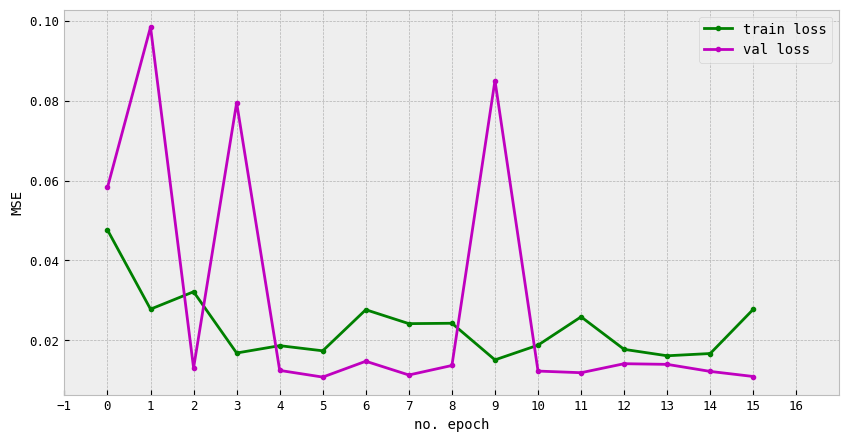

In [81]:
train_mse = model_entire.evaluate(X_train_sc, y_train_sc, verbose=0)
val_mse = model_entire.evaluate(X_val_sc, y_val_sc, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_mse, val_mse))

# plot loss during training
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], 'g.-', label='train loss')
plt.plot(history.history['val_loss'], 'm.-', label='val loss')
plt.legend()
plt.gca().set(xlim=(-1,len(history.history['loss'])+1), xlabel='no. epoch', ylabel='MSE') 
plt.xticks(np.arange(-1, len(history.history['loss'])+1, 1));

452/452 [==============================] - 1s 1ms/step


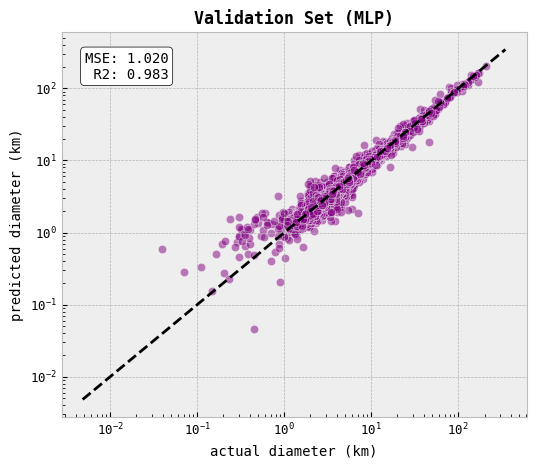

In [82]:
# Make predictions for validation and test set.
y_pred_sc = model_entire.predict(X_val_sc)
y_pred = scaler.inverse_transform(y_pred_sc)   # unscale predicted diameters

# Plot predictions vs actual values.
plt.figure(figsize=(6,5))
plt.gca().set(xscale='log', yscale='log', title='Validation Set (MLP)', xlabel='actual diameter (km)', ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='purple', alpha=0.5);

# MLP trained on dataset without approx_diameter feature

In [83]:
model_red = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train_sc_red.shape[1:]),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

model_red.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(), )

In [84]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model_red.fit(X_train_sc_red, y_train_sc, epochs=50, 
                        validation_data=(X_val_sc_red, y_val_sc),
                        callbacks=[early_stopping_cb])

Epoch 1/50
2560/2560 [==============================] - 7s 2ms/step - loss: 0.5039 - val_loss: 0.1696
Epoch 2/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.2497 - val_loss: 2.3692
Epoch 3/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.3041 - val_loss: 0.0632
Epoch 4/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.1591 - val_loss: 0.3289
Epoch 5/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.1682 - val_loss: 0.0255
Epoch 6/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.1185 - val_loss: 0.0535
Epoch 7/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.1619 - val_loss: 0.1387
Epoch 8/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.1443 - val_loss: 0.0467
Epoch 9/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.1064 - val_loss: 0.0332
Epoch 10/50
2560/2560 [==============================] - 6s 2ms/step - loss: 0.064

Train: 0.108, Val: 0.026


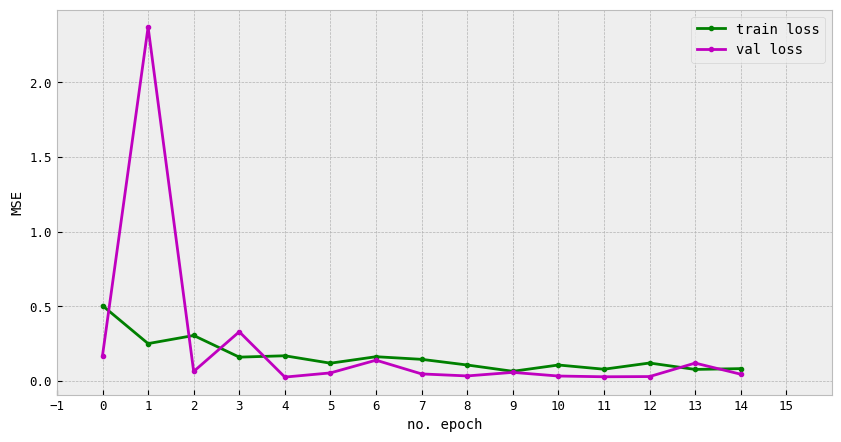

In [85]:
train_mse = model_red.evaluate(X_train_sc_red, y_train_sc, verbose=0)
val_mse = model_red.evaluate(X_val_sc_red, y_val_sc, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_mse, val_mse))

# plot loss during training
fig = plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], 'g.-', label='train loss')
plt.plot(history.history['val_loss'], 'm.-', label='val loss')
plt.legend()
plt.gca().set(xlim=(-1,len(history.history['loss'])+1), xlabel='no. epoch', ylabel='MSE') 
plt.xticks(np.arange(-1, len(history.history['loss'])+1, 1));

452/452 [==============================] - 1s 1ms/step


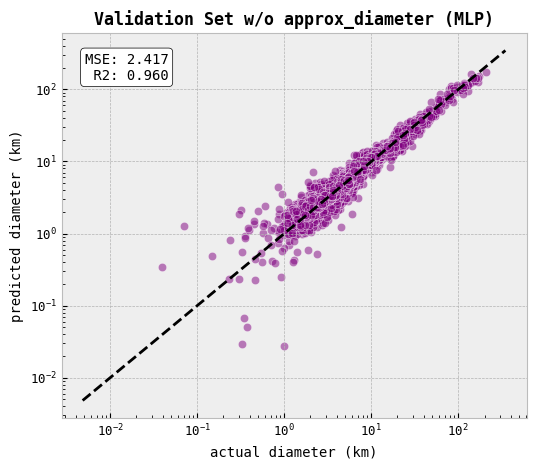

In [86]:
# Make predictions for validation and test set.
y_pred_sc = model_red.predict(X_val_sc_red)
y_pred = scaler.inverse_transform(y_pred_sc)   # unscale predicted diameters

# Plot predictions vs actual values.
plt.figure(figsize=(6,5))
plt.gca().set(xscale='log', yscale='log', title='Validation Set w/o approx_diameter (MLP)', xlabel='actual diameter (km)', 
              ylabel='predicted diameter (km)')
evaluation_scatterplot(y_pred, y_val, color='purple', alpha=0.5);

1291/1291 [==============================] - 2s 1ms/step


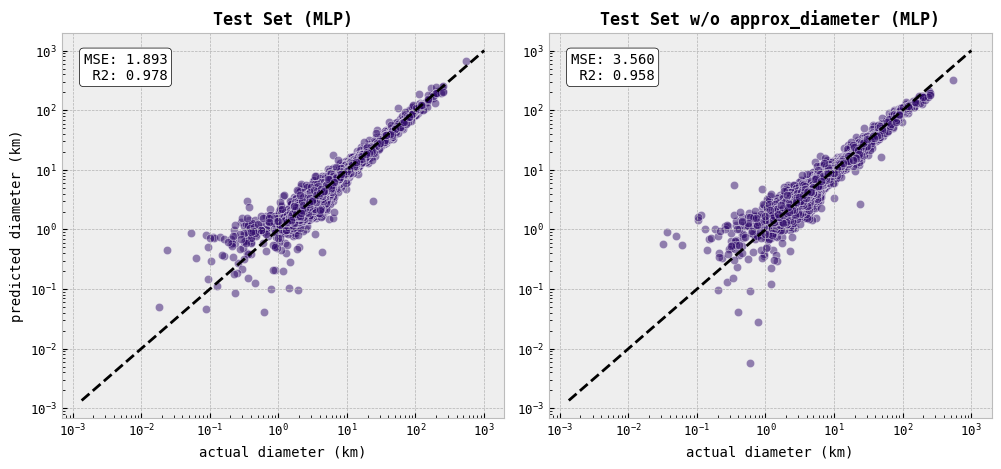

In [87]:
y_pred_test_sc = model_entire.predict(X_test_sc)
y_pred_test = scaler.inverse_transform(y_pred_test_sc)

y_pred_test_sc_red = model_red.predict(X_test_sc_red)
y_pred_test_red = scaler.inverse_transform(y_pred_test_sc_red)

# Plot predictions vs actual values.
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.subplot(121, xscale='log', yscale='log', title='Test Set (MLP)', xlabel='actual diameter (km)', ylabel='predicted diameter (km)')
ax, mse_mlp, r2_mlp = evaluation_scatterplot(y_pred_test, y_test, color='#320D6D', alpha=0.5);

plt.subplot(122, xscale='log', yscale='log', title='Test Set w/o approx_diameter (MLP)', xlabel='actual diameter (km)')
ax, mse_mlp_red, mse_mlp_r2 = evaluation_scatterplot(y_pred_test_red, y_test, color='#320D6D', alpha=0.5);

In [88]:
test_results = pd.DataFrame()

# Add the scores of the first model.
test_results = test_results._append({
    'Model':'MLP', 
    'MSE':mse_mlp, 
    'R2':r2_mlp
}, ignore_index=True,)
test_results

Model    MSE     R2
0   MLP  1.893  0.978

In [89]:

asteroid

a         e          i          om           w         q  \
0       2.769165  0.076009  10.594067   80.305532   73.597694  2.558684   
1       2.772466  0.230337  34.836234  173.080063  310.048857  2.133865   
2       2.669150  0.256942  12.988919  169.852760  248.138626  1.983332   
3       2.361418  0.088721   7.141771  103.810804  150.728541  2.151909   
4       2.574249  0.191095   5.366988  141.576605  358.687607  2.082324   
...          ...       ...        ...         ...         ...       ...   
797860  3.171225  0.159119  27.098625  309.036573   19.746812  2.666623   
798077  2.548410  0.076071  11.593237  246.298656  170.090810  2.354549   
798189  3.146246  0.220559  17.966646  137.981403  180.898833  2.452313   
799752  3.051336  0.287449  14.456779  343.917822  342.614839  2.174231   
810375  2.417477  0.109001   4.525668  148.244819   31.949854  2.153970   

              ad     per_y    data_arc condition_code  n_obs_used      H neo  \
0       2.979647  4.608202   24.169863              0        1002   3.34   N   
1       3.411067  4.616444  198.131507              0        8490   4.13   N   
2       3.354967  4.360814  199.134247              0        7104   5.33   N   
3       2.570926  3.628837   66.542466              0        9325   3.20   N   
4       3.066174  4.130323  173.991781              0        2916   6.85   N   
...          ...       ...         ...            ...         ...    ...  ..   
797860  3.675826  5.647402    6.501370              1          50  16.20   N   
798077  2.742270  4.068291    9.032877              2          33  17.30   N   
798189  3.840180  5.580811    7.778082              1          47  16.80   N   
799752  3.928440  5.330196    6.049315              2          27  17.20   N   
810375  2.680984  3.758822    9.473973              3          25  18.40   N   

       pha  diameter  albedo     moid class         n          ma  
0        N   939.400  0.0900  1.59478   MBA  0.213885   77.372096  
1        N   545.000  0.1010  1.23324   MBA  0.213503   59.699133  
2        N   246.596  0.2140  1.03454   MBA  0.226019   34.925016  
3        N   525.400  0.4228  1.13948   MBA  0.271609   95.861936  
4        N   106.699  0.2740  1.09589   MBA  0.238632  282.366289  
...     ..       ...     ...      ...   ...       ...         ...  
797860   N     3.793  0.0210  1.66301   MBA  0.174527  164.999439  
798077   N     2.696  0.0610  1.36733   MBA  0.242270  145.319581  
798189   N     2.917  0.1540  1.43837   MBA  0.176610  174.609920  
799752   N     3.271  0.0720  1.16684   MBA  0.184914  175.708508  
810375   N     1.600  0.0230  1.15942   MBA  0.262217  170.888415  

[137636 rows x 20 columns]